In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#path_wd='drive/MyDrive/MINDAT Aspectos Avanzados/lulc-classification'
#os.chdir(path_wd)

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


Cargamos las bibliotecas necesarias

In [18]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.utils import np_utils
import cv2
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers  #Para definición de capas
from numpy.random import seed           #Para controlar generación de pesos
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Para procesado de imágenes
import tensorflow.random
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Para procesado de imágenes

from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split


from keras.applications.resnet import ResNet50


Consideramos unas semillas aleatorias para garantizar reproducibilidad en los experimentos

In [4]:
seed(1)
tensorflow.random.set_seed(0)

Fijamos los paths donde se encuentran las imagenes

In [5]:
train_dir = "./Sentinel2LULC_354/Sentinel2LULC_354"
test_dir = "./Test 2/Test 2"
weights_file = None

Vamos a definir funciones auxiliares que nos ayudarán a visualizar diferentes aspectos

La primera función irá destinada a calcular la precisión total del modelo

In [6]:
def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  accuracy = sum(labels == preds)/len(labels)
  return accuracy

Vamos a hacer también una función para calcular la precisión por clase en el modelo

In [7]:
def calcularAccuracyClases(labels, preds):
  well_pred = np.zeros(labels.shape[1]).tolist()
  total = np.zeros(labels.shape[1]).tolist()

  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)

  for i in len(labels):
    total[labels[i]] += 1
    if labels[i] == preds[i]:
      well_pred[labels[i]] += 1
  
  for i in len(well_pred):
    well_pred[i] /= float(total[i])
  
  return well_pred

Vamos a hacer una función también para visualizar la evolución de la medida de interés (accuracy en este caso) en entrenamiento y validación para cada época

In [8]:
def mostrarEvolucion(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()


  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy','Validation accuracy'])
  plt.ylim(0,1)           #Meto esto para mejor comparación de gráficas
  plt.show()

Realizamos la lectura de las imagenes

In [9]:
print("--- LECTURA DE IMÁGENES ---")

print("- Cargando imágenes de entrenamiento...")

x_train = []
y_train = []

for root, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".jpg"):               
            x_train.append(cv2.imread(os.path.join(root, file), 1))
            y_train.append(int(file.split("_")[0]))

x_test = []
y_test = []
names_test = []

print("- Cargando imágenes de test...")

for root, _, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".jpg"):               
            x_test.append(cv2.imread(os.path.join(root, file), 1))
            y_test.append(int(file.split("_")[0]))
            names_test.append(file)

            
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

train, val = train_test_split(np.arange(len(y_train)), test_size=0.2, random_state=5, stratify=y_train)

x_val = x_train[val]
y_val = y_train[val]
y_train = y_train[train]
x_train = x_train[train]


--- LECTURA DE IMÁGENES ---
- Cargando imágenes de entrenamiento...
- Cargando imágenes de test...


(9239, 224, 224, 3)
(9239,)
Epoch 1/70


C:\Users\Piwi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


289/289 [==============================] - 40s 127ms/step - loss: 1.3991 - categorical_accuracy: 0.6254 - val_loss: 1.6569 - val_categorical_accuracy: 0.5920
Epoch 2/70
289/289 [==============================] - 36s 125ms/step - loss: 0.5195 - categorical_accuracy: 0.8281 - val_loss: 0.6991 - val_categorical_accuracy: 0.7877
Epoch 3/70
289/289 [==============================] - 36s 126ms/step - loss: 0.3466 - categorical_accuracy: 0.8796 - val_loss: 0.5157 - val_categorical_accuracy: 0.8403
Epoch 4/70
289/289 [==============================] - 36s 125ms/step - loss: 0.2309 - categorical_accuracy: 0.9208 - val_loss: 0.6741 - val_categorical_accuracy: 0.8082
Epoch 5/70
289/289 [==============================] - 36s 126ms/step - loss: 0.1585 - categorical_accuracy: 0.9444 - val_loss: 0.6751 - val_categorical_accuracy: 0.8033
Epoch 6/70
289/289 [==============================] - 36s 126ms/step - loss: 0.1332 - categorical_accuracy: 0.9532 - val_loss: 0.4459 - val_categorical_accuracy: 0.86

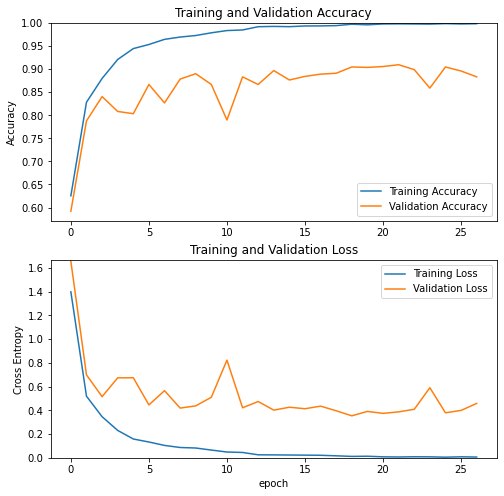

51/51 [==============================] - 2s 36ms/step - loss: 0.2143 - categorical_accuracy: 0.9326
Test loss: 0.21425001323223114, test acc: 0.9326328635215759


<ipython-input-25-dbd1191203fe>:89: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_matrix = confusion_matrix(y_true=y_val-1, y_pred=val_preds).astype(np.float)
<ipython-input-25-dbd1191203fe>:90: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_matrix /= val_matrix.astype(np.float).sum(axis=1)
<ipython-input-25-dbd1191203fe>:94: Depre

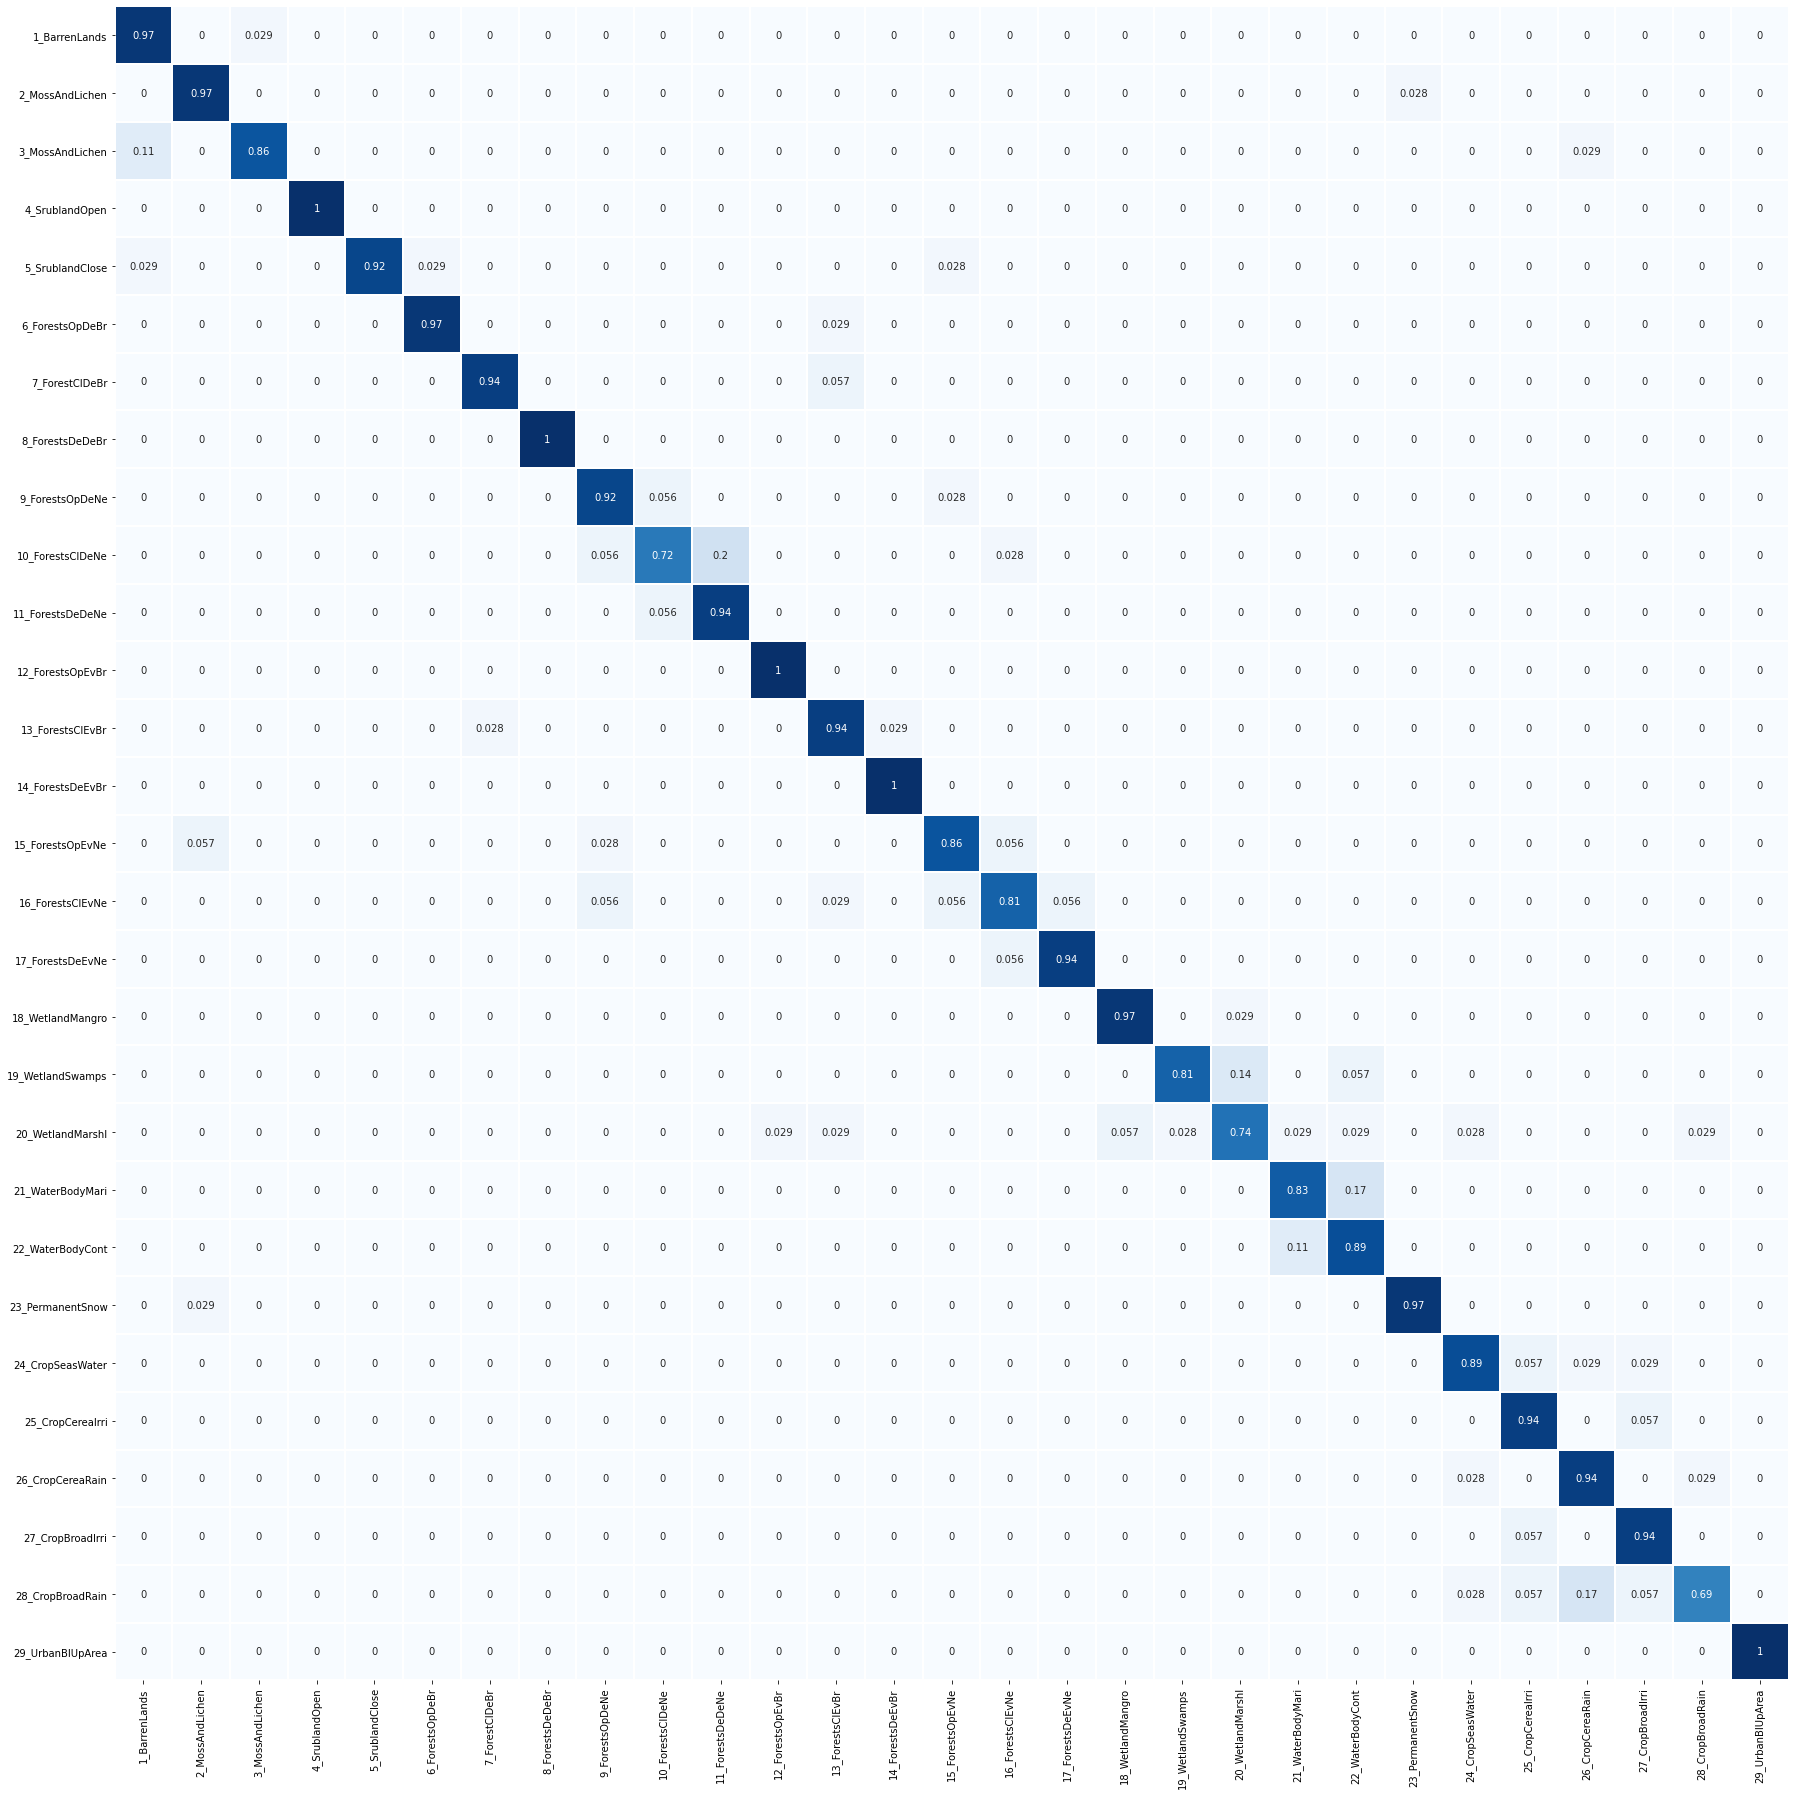

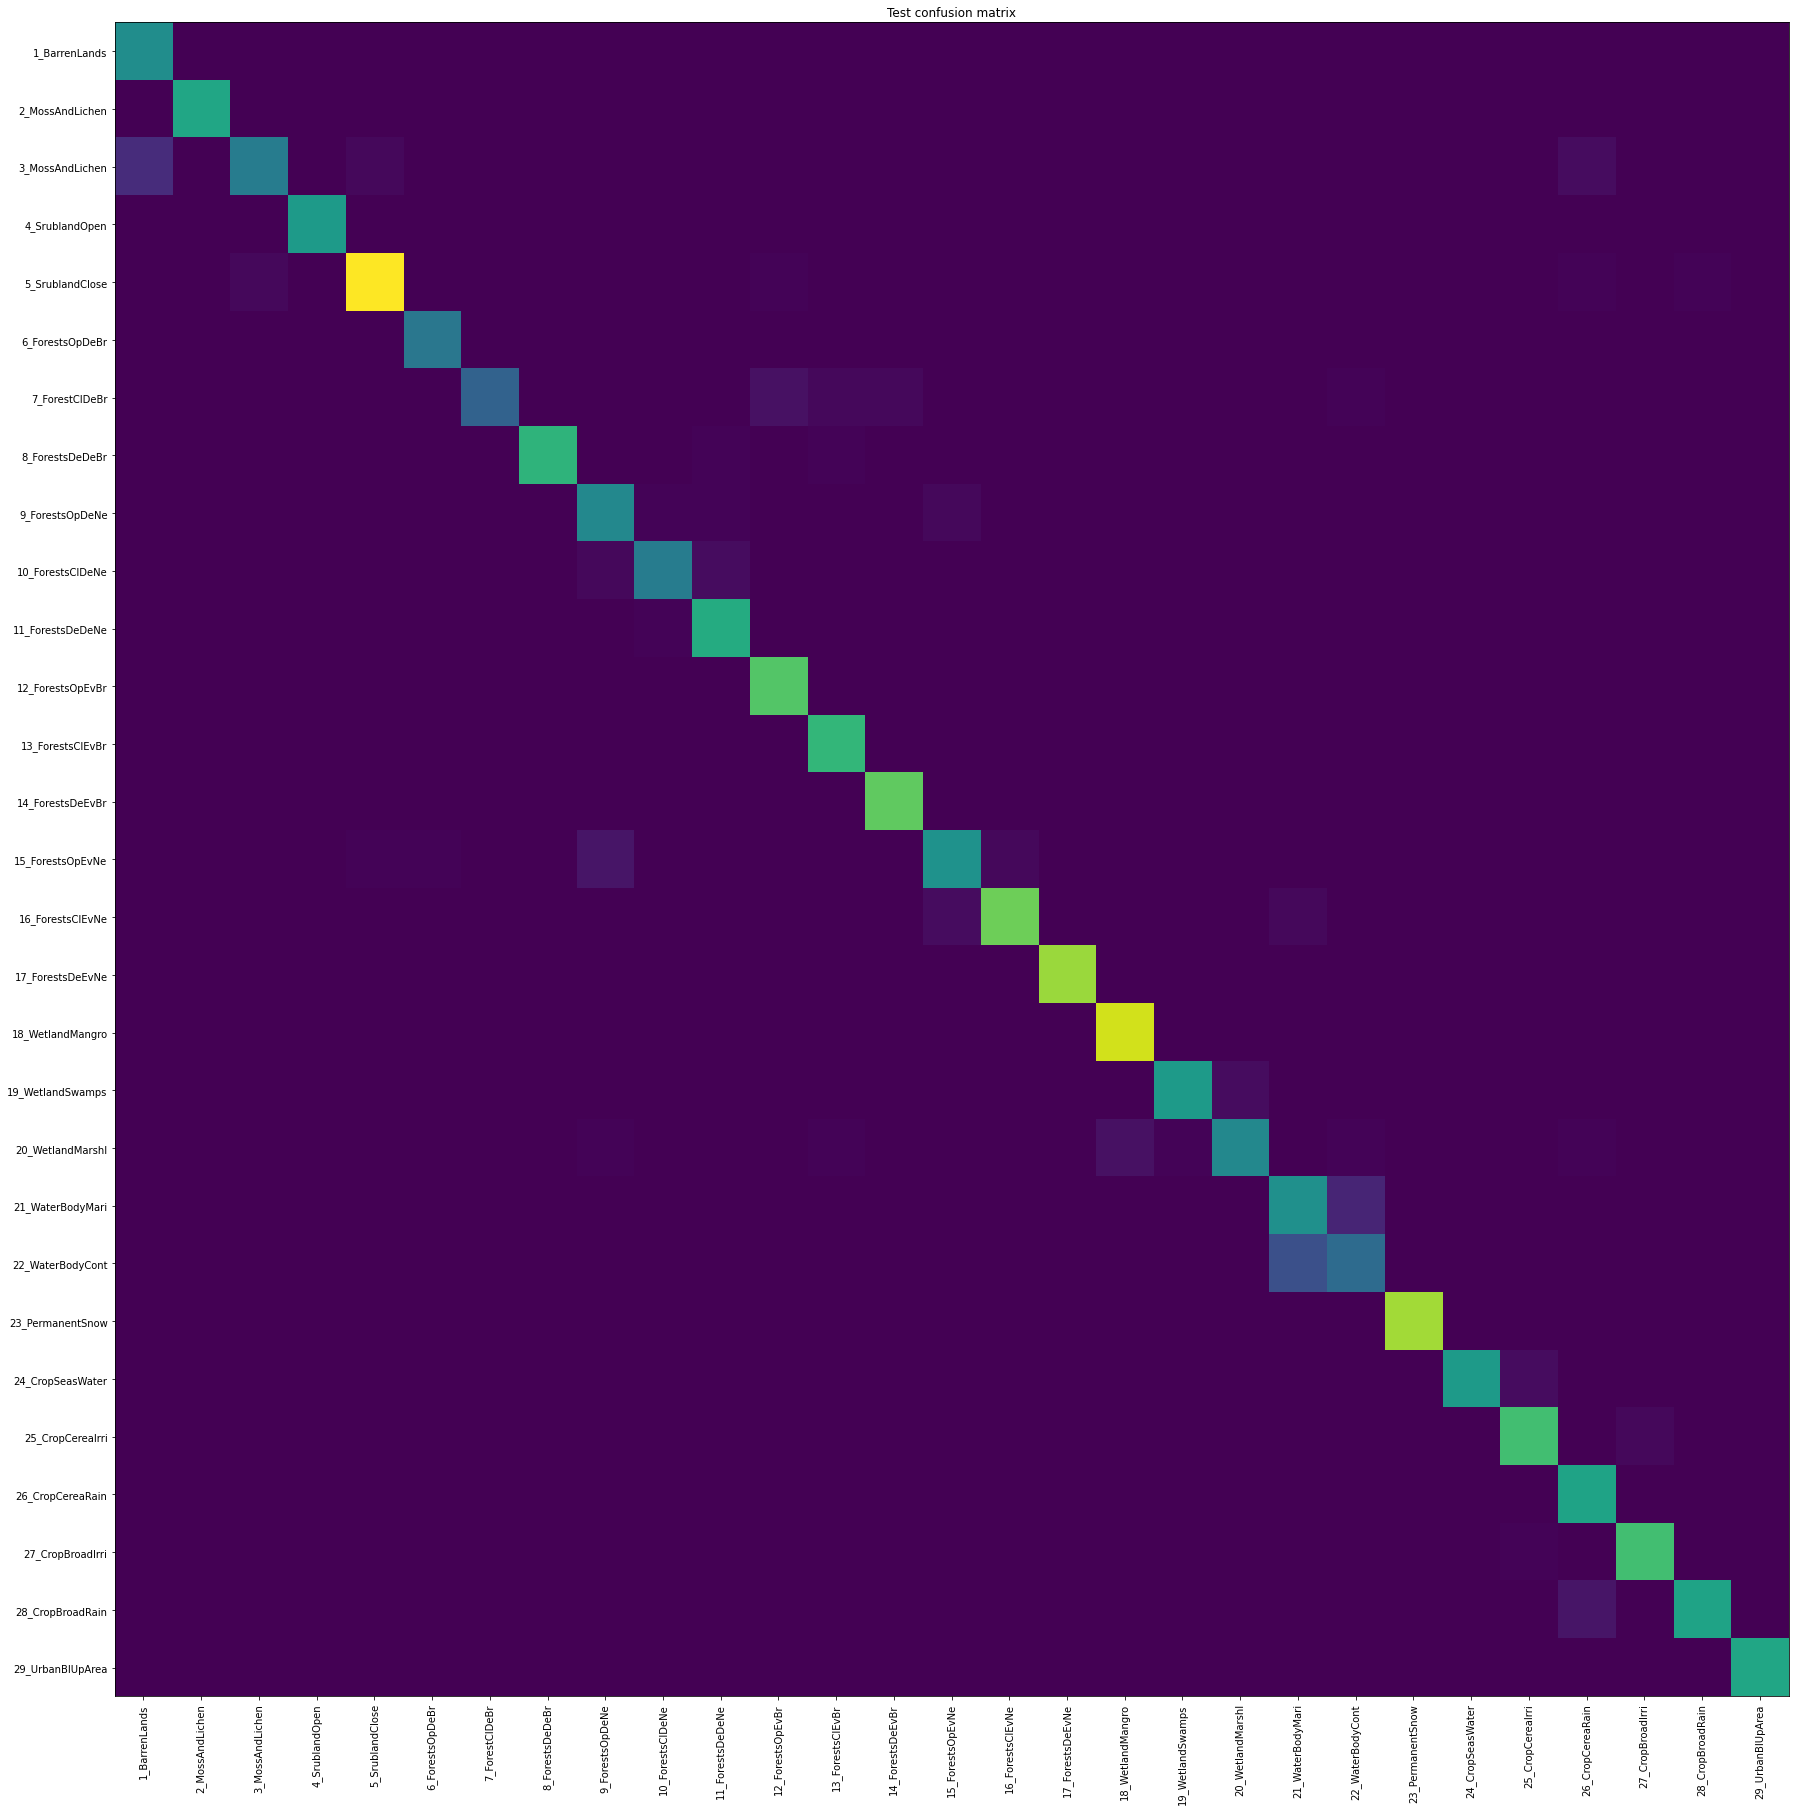

In [25]:
load_file = None

batch_size = 32
shuffle_buffer_size = 1000

nclasses = len(np.unique(y_train))
img_shape = x_train.shape[1:4]

y_train_coded = tf.one_hot(y_train-1, depth=nclasses, on_value=1, off_value=0)
y_val_coded = tf.one_hot(y_val-1, depth=nclasses, on_value=1, off_value=0)
y_test_coded = tf.one_hot(y_test-1, depth=nclasses, on_value=1, off_value=0)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train_coded)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val), tf.convert_to_tensor(y_val_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_test), tf.convert_to_tensor(y_test_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)


print(x_train.shape)
print(y_train.shape)

nclasses = 29
epochs = 70

subida = "4"

def create_model(base_model):
  base_model.trainable = True
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nclasses, activation='softmax')
  ])
  return model


def train_evaluate_model(model, name, lr=0.0001):
  earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    verbose=1,
    mode='max',
    patience=5,
    restore_best_weights=True
  )
  #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])
  model.save_weights('david/modelos/model' +subida + '.h5')

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,(np.max(val_loss)+0.01)])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  test_loss, test_acc = model.evaluate(test_batches)
  print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))
  
  val_preds = np.argmax(model.predict(x_val), axis=-1)
  val_matrix = confusion_matrix(y_true=y_val-1, y_pred=val_preds).astype(np.float)
  val_matrix /= val_matrix.astype(np.float).sum(axis=1)


  test_preds = np.argmax(model.predict(x_test), axis=-1)
  test_matrix = confusion_matrix(y_true=y_test-1, y_pred=test_preds).astype(np.float)

  axlabs = [
  "1_BarrenLands",
  "2_MossAndLichen",
  "3_MossAndLichen",
  "4_SrublandOpen",
  "5_SrublandClose",
  "6_ForestsOpDeBr",
  "7_ForestClDeBr",
  "8_ForestsDeDeBr",
  "9_ForestsOpDeNe",
  "10_ForestsClDeNe",
  "11_ForestsDeDeNe",
  "12_ForestsOpEvBr",
  "13_ForestsClEvBr",
  "14_ForestsDeEvBr",
  "15_ForestsOpEvNe",
  "16_ForestsClEvNe",
  "17_ForestsDeEvNe",
  "18_WetlandMangro",
  "19_WetlandSwamps",
  "20_WetlandMarshl",
  "21_WaterBodyMari",
  "22_WaterBodyCont",
  "23_PermanentSnow",
  "24_CropSeasWater",
  "25_CropCerealrri",
  "26_CropCereaRain",
  "27_CropBroadlrri",
  "28_CropBroadRain",
  "29_UrbanBlUpArea",

  ]
  """
  fig, ax = plt.subplots(figsize=(30,50))
  im = ax.imshow(val_matrix)
  ax.set_xticks(np.arange(nclasses))
  ax.set_yticks(np.arange(nclasses))
  ax.set_xticklabels(axlabs, rotation='vertical')
  ax.set_yticklabels(axlabs)
  ax.set_title("Validation conf matrix")
  plt.show()
  """
  fig, ax = plt.subplots(figsize=(30, 50))         # Sample figsize in inches
  sns.heatmap(val_matrix, annot=True, cmap='Blues', cbar=False, linewidths=1, square=True, xticklabels=axlabs, yticklabels=axlabs)
  
  sns
  fig, ax = plt.subplots(figsize=(30,50))
  im = ax.imshow(test_matrix)
  ax.set_xticks(np.arange(nclasses))
  ax.set_yticks(np.arange(nclasses))
  ax.set_xticklabels(axlabs, rotation='vertical')
  ax.set_yticklabels(axlabs)
  ax.set_title("Test confusion matrix")
  plt.show()
  
  
def prep_finetuning(model, from_layer):
  model.layers[0].trainable = True
  for layer in model.layers[0].layers[:from_layer]:
    layer.trainable =  False


def predictions_file(model):
  predictions = model.predict(x_test)
  preds = np.argmax(predictions, axis=-1) + 1
  output = pd.DataFrame({'id.jpg': y_test, 'label':preds})
  output.to_csv('david/predicciones/pred' + subida + '.csv', header=True, index=False)
    
    
    
    
    
base = tf.keras.applications.ResNet50(include_top = False, weights='imagenet',
                                         input_shape=img_shape, pooling='max')
model_avgg = create_model(base)


if load_file is not None:
    model_avgg.load_weights(load_file)
train_evaluate_model(model_avgg, 'avgg19_256_128')

predictions_file(model_avgg)

#m_avgg = load_model(path_models + 'avgg19_256_128.h5')
#prep_finetuning(m_avgg, 20)
#train_evaluate_model(m_avgg, 'avgg19_256_128_v2', 0.00001)

Definimos ahora el modelo que vamos a utilizar

Ejecutamos el modelo

Realizamos la predicción sobre el conjunto de test

Calculamos algunas medidas de interés sobre la predicción realizada